In [1]:
from torchvision import transforms #add this line in the above snippet
from torch.utils.data import DataLoader #add this line in the above snippet
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from caltech256 import Caltech256
from torchvision.utils import make_grid


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", data_transforms['train'], train=True)
train_data = DataLoader(
    dataset = caltech256_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
)

caltech256_test = Caltech256("/datasets/Caltech256/256_ObjectCategories/", data_transforms['test'], train=False)
test_data = DataLoader(
    dataset = caltech256_test,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
)
use_gpu = torch.cuda.is_available()
'''
##dataloaders = {'train' : train_data, 'test' : test_data}

dataset = {x: Caltech256("/datasets/Caltech256/256_ObjectCategories/", data_transforms[x], x=='train')
           for x in ('train', 'test')}
#print(dataset)
print(len(dataset['train']))
dataloaders = {x: DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ('train', 'test')}

dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'test']}

use_gpu = torch.cuda.is_available()
'''




'\n##dataloaders = {\'train\' : train_data, \'test\' : test_data}\n\ndataset = {x: Caltech256("/datasets/Caltech256/256_ObjectCategories/", data_transforms[x], x==\'train\')\n           for x in (\'train\', \'test\')}\n#print(dataset)\nprint(len(dataset[\'train\']))\ndataloaders = {x: DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=4)\n              for x in (\'train\', \'test\')}\n\ndataset_sizes = {x: len(dataloaders[x]) for x in [\'train\', \'test\']}\n\nuse_gpu = torch.cuda.is_available()\n'

In [3]:
type(train_data)

torch.utils.data.dataloader.DataLoader

In [4]:
## Train the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc = []
    train_loss= []
    test_acc = []
    test_loss= []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #train mode
        scheduler.step()
        model.train(True)  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_data, 0):
            # get the inputs
            inputs, labels = data
            labels = labels.long().squeeze(1) - 1
            #labels = labels.long()
            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            
            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()



            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            
            running_loss += loss.data[0] * inputs.size(0)
            #print(running_loss)
            #print (i, ":")
            #print ("pred:", preds)
            #print ("labels", labels.data)
            running_corrects += torch.sum(preds == labels.data)
            #print ("running_corrects:", running_corrects)
        
        epoch_loss = running_loss / len(caltech256_train)
        epoch_acc = running_corrects / len(caltech256_train)
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'train', epoch_loss, epoch_acc))

        #test mode
        model.train(False)  
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(test_data, 0):
            # get the inputs
            inputs, labels = data
            labels = labels.long().squeeze(1) - 1
            #labels = labels.long()
            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            #optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            #print(inputs.size(), labels.size(), outputs.size())
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.data[0] * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(caltech256_test)
        epoch_acc = running_corrects / len(caltech256_test)
        test_acc.append(epoch_acc)
        test_loss.append(epoch_loss)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'test', epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, test_loss, train_acc, test_acc

In [6]:
#ConvNet as fixed feature extractor
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier._modules['6'] = nn.Linear(4096, 256)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier._modules['6'].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

#Train and Evaluate
model_conv, train_loss, test_loss, train_acc, test_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

#visualize_model(model_conv)

#plt.ioff()
#plt.show()



Epoch 0/24
----------
train Loss: 4.5235 Acc: 0.2139
test Loss: 2.9813 Acc: 0.6016
Epoch 1/24
----------
train Loss: 2.8460 Acc: 0.5232
test Loss: 1.9667 Acc: 0.6914
Epoch 2/24
----------
train Loss: 2.1623 Acc: 0.6157
test Loss: 1.5605 Acc: 0.7207
Epoch 3/24
----------
train Loss: 1.8369 Acc: 0.6526
test Loss: 1.3613 Acc: 0.7358
Epoch 4/24
----------
train Loss: 1.6585 Acc: 0.6659
test Loss: 1.2403 Acc: 0.7466
Epoch 5/24
----------
train Loss: 1.5480 Acc: 0.6771
test Loss: 1.1650 Acc: 0.7500
Epoch 6/24
----------
train Loss: 1.4235 Acc: 0.6921
test Loss: 1.1094 Acc: 0.7559
Epoch 7/24
----------
train Loss: 1.3527 Acc: 0.7081
test Loss: 1.0723 Acc: 0.7598
Epoch 8/24
----------
train Loss: 1.3045 Acc: 0.7122
test Loss: 1.0401 Acc: 0.7598
Epoch 9/24
----------
train Loss: 1.2521 Acc: 0.7185
test Loss: 1.0185 Acc: 0.7637
Epoch 10/24
----------
train Loss: 1.2199 Acc: 0.7255
test Loss: 1.0147 Acc: 0.7632
Epoch 11/24
----------
train Loss: 1.2113 Acc: 0.7286
test Loss: 1.0114 Acc: 0.7632
Ep

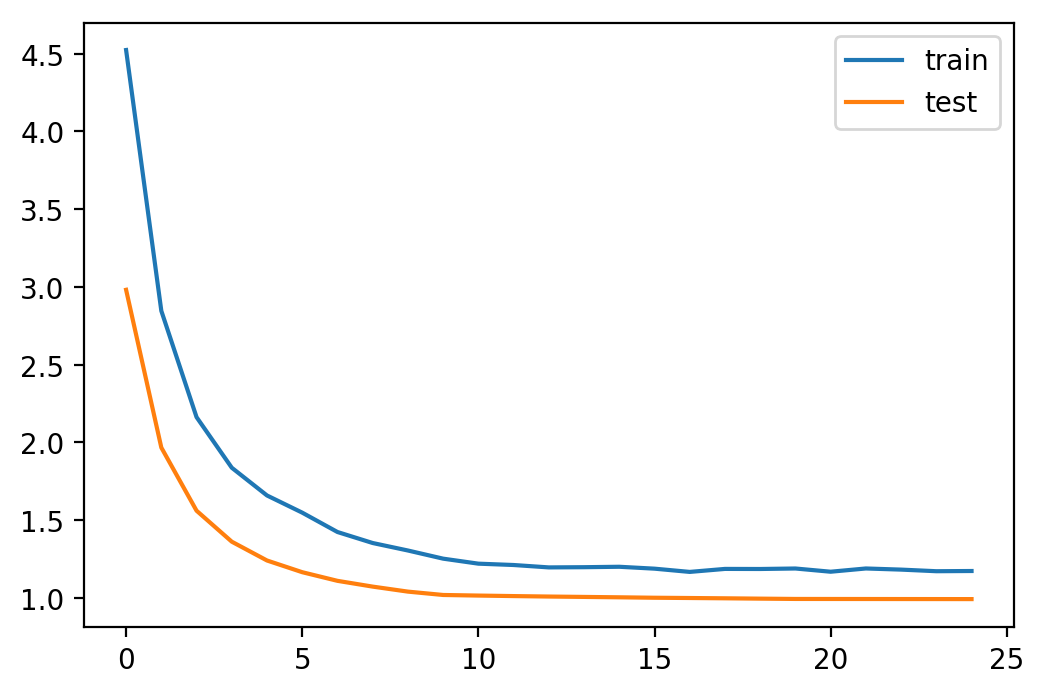

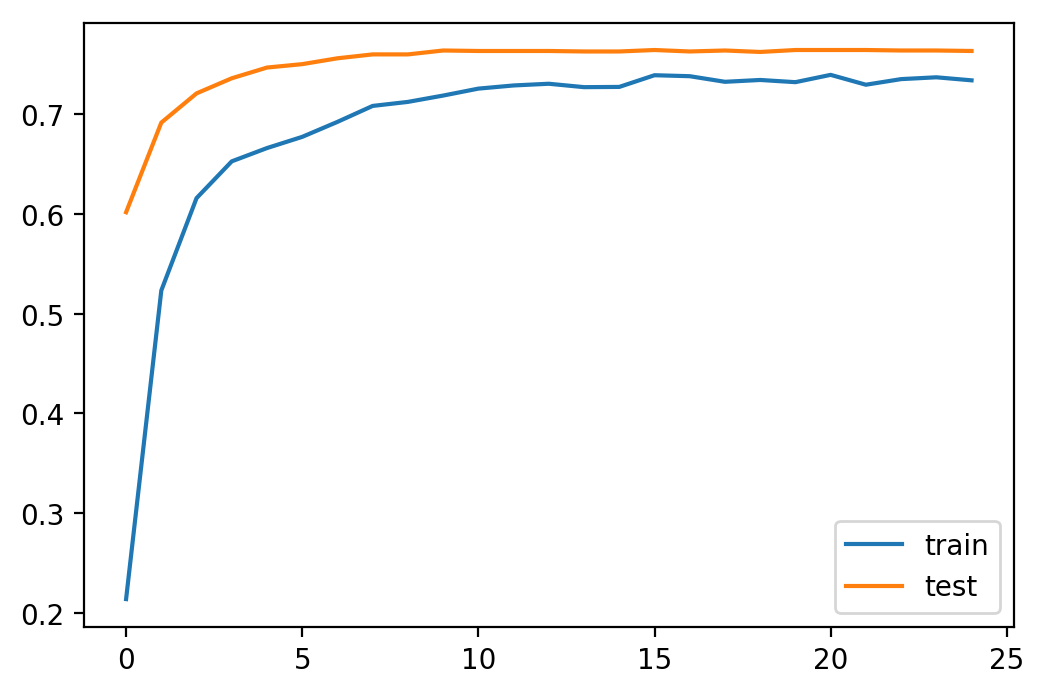

In [8]:
plt.figure(dpi=200)
plt.plot(train_loss,label = "train")
plt.plot(test_loss,label = "test")
plt.legend()
plt.show()
plt.figure(dpi=200)
plt.plot(train_acc, label = "train")
plt.plot(test_acc, label = "test")
plt.legend()
plt.show()



In [26]:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    

model_conv = torchvision.models.vgg16(pretrained=True)
#mm = model_conv.double()
filters = model_conv.modules
body_model = [i for i in model_conv.children()][0]
layer1 = body_model[0]
tensor = layer1.weight.data.cpu().numpy()
plot_kernels(tensor)

ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

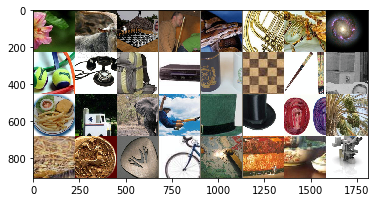

In [20]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def _visualize_batch(output=None):
        data, label = next(iter(train_data))
        imgs = make_grid(data)
        imgs = imgs.numpy().transpose((1,2,0))
        imgs = imgs * STD + MEAN
        imgs = np.clip(imgs, 0, 1)
        plt.figure()
        plt.imshow(imgs)
        if output is None:
            plt.show()
        else:
            plt.savefig(output)
_visualize_batch()


In [9]:
model_conv = torchvision.models.vgg16(pretrained=True)

In [7]:
class Modified_VGG3(nn.Module):
            def __init__(self):
                super(Modified_VGG3, self).__init__()
                self.features = nn.Sequential(
                    # stop at block3
                    *list(model_conv.features.children())[:17]
                )
                self.classifier = nn.Sequential(nn.Linear(200704, 1024), nn.Linear(1024,256))

            def forward(self, x):
                x = self.features(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return x

model_conv_3 = Modified_VGG3()

In [8]:
#ConvNet as fixed feature extractor
for param in model_conv_3.features.parameters():
    param.requires_grad = False
for param in model_conv_3.classifier.parameters():
    param.requires_grad = True
    
if use_gpu:
    model_conv_3 = model_conv_3.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv_3.classifier.parameters(), lr=0.00001, momentum=0.9)
#optimizer_conv = optim.Adam(model_conv_3.classifier.parameters() lr=0.00001, betas=0.95, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

#Train and Evaluate
model_conv_3 = train_model(model_conv_3, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.1189 Acc: 0.0214
test Loss: 5.5380 Acc: 0.0625
Epoch 1/29
----------
train Loss: 5.2194 Acc: 0.0729
test Loss: 4.9146 Acc: 0.1177
Epoch 2/29
----------
train Loss: 4.7350 Acc: 0.1244
test Loss: 4.6272 Acc: 0.1548
Epoch 3/29
----------
train Loss: 4.3816 Acc: 0.1660
test Loss: 4.2752 Acc: 0.1943
Epoch 4/29
----------
train Loss: 4.1286 Acc: 0.1931
test Loss: 4.1745 Acc: 0.2114
Epoch 5/29
----------
train Loss: 3.9608 Acc: 0.2118
test Loss: 3.9857 Acc: 0.2402
Epoch 6/29
----------
train Loss: 3.8122 Acc: 0.2404
test Loss: 3.8804 Acc: 0.2485
Epoch 7/29
----------
train Loss: 3.6482 Acc: 0.2635
test Loss: 3.8358 Acc: 0.2578
Epoch 8/29
----------
train Loss: 3.5682 Acc: 0.2830
test Loss: 3.7363 Acc: 0.2808
Epoch 9/29
----------
train Loss: 3.4252 Acc: 0.2991
test Loss: 3.6768 Acc: 0.2803
Epoch 10/29
----------
train Loss: 3.2290 Acc: 0.3235
test Loss: 3.4817 Acc: 0.3052
Epoch 11/29
----------
train Loss: 3.1531 Acc: 0.3354
test Loss: 3.4736 Acc: 0.3071
Ep

In [15]:
class Modified_VGG4(nn.Module):
            def __init__(self):
                super(Modified_VGG4, self).__init__()
                self.features = nn.Sequential(
                    # stop at block4
                    *list(model_conv.features.children())[:24]
                )
                self.classifier = nn.Sequential(nn.Linear(100352, 1024), nn.Linear(1024 ,256))

            def forward(self, x):
                x = self.features(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return x

model_conv_4 = Modified_VGG4()
print(model_conv_4)

Modified_VGG4 (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=

In [19]:
for param in model_conv_4.features.parameters():
    param.requires_grad = False
for param in model_conv_4.classifier.parameters():
    param.requires_grad = True

if use_gpu:
    model_conv_4 = model_conv_4.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
#optimizer_conv = optim.SGD(model_conv_4.classifier.parameters(), lr=0.00001, momentum=0.95)

optimizer_conv = optim.Adam(model_conv_4.classifier.parameters(), lr=0.00001, betas=(0.9, 0.999), weight_decay=0.1)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

#Train and Evaluate
model_conv_4 = train_model(model_conv_4, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 3.3139 Acc: 0.3219
test Loss: 2.7241 Acc: 0.4170
Epoch 1/49
----------
train Loss: 2.7099 Acc: 0.4301
test Loss: 2.4096 Acc: 0.4824
Epoch 2/49
----------
train Loss: 2.3163 Acc: 0.5024
test Loss: 2.2551 Acc: 0.5122
Epoch 3/49
----------
train Loss: 2.1332 Acc: 0.5354
test Loss: 2.1979 Acc: 0.5161
Epoch 4/49
----------
train Loss: 1.9871 Acc: 0.5659
test Loss: 2.0594 Acc: 0.5400
Epoch 5/49
----------
train Loss: 1.8661 Acc: 0.5973
test Loss: 2.0406 Acc: 0.5469
Epoch 6/49
----------
train Loss: 1.7643 Acc: 0.6230
test Loss: 1.9815 Acc: 0.5562
Epoch 7/49
----------
train Loss: 1.6879 Acc: 0.6370
test Loss: 1.9422 Acc: 0.5610
Epoch 8/49
----------
train Loss: 1.6271 Acc: 0.6525
test Loss: 1.9604 Acc: 0.5669
Epoch 9/49
----------
train Loss: 1.6062 Acc: 0.6519
test Loss: 1.9183 Acc: 0.5703
Epoch 10/49
----------
train Loss: 1.4409 Acc: 0.7069
test Loss: 1.7989 Acc: 0.6035
Epoch 11/49
----------
train Loss: 1.3896 Acc: 0.7174
test Loss: 1.7862 Acc: 0.6079
Ep

In [72]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_data):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        labels = labels.long().squeeze(1) - 1
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, labels:{}'.format(preds[j], labels[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
